In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils import resample
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [2]:
# ==== Load and Prepare Data ====
samples = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_dataframe_proc.csv')
tests = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_tests_proc.csv')

X_train = samples.iloc[:, :-1]
y_train = samples.iloc[:, -1]
X_test = tests.iloc[:, :-1]
y_test = tests.iloc[:, -1]

# ==== Upsample ====
df = pd.concat([X_train, y_train], axis=1)
normal = df[df['Label'] == 0]
ddos = df[df['Label'] == 1]
normal_upsampled = resample(normal, replace=True, n_samples=len(ddos), random_state=27)
upsampled = pd.concat([normal_upsampled, ddos])
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

# ==== Normalize ====
scaler = MinMaxScaler((-1, 1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# ==== Evaluation Function ====
def evaluate_model(model, X_train, y_train, X_test, y_test, params):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Detection rates
    true_normal = (y_test == 0)
    true_attack = (y_test == 1)
    normal_detect_rate = (y_pred[true_normal] == 0).sum() / true_normal.sum()
    attack_detect_rate = (y_pred[true_attack] == 1).sum() / true_attack.sum()

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Normal_Detect_Rate': normal_detect_rate,
        'Atk_Detect_Rate': attack_detect_rate,
        'Training_Time': train_time,
        'Confusion_Matrix': confusion_matrix(y_test, y_pred).tolist(),
        'ROC_FPR': fpr.tolist(),
        'ROC_TPR': tpr.tolist(),
        'ROC_AUC': roc_auc,
        **params
    }

# ==== Grid Search ==== 
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

results = []

for params in ParameterGrid(param_grid):
    print(f"Training Logistic Regression with {params}")
    model = LogisticRegression(**params, max_iter=1000)
    
    # Cross-validation to calculate the mean test score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_test_score = np.mean(cv_scores)
    
    # Evaluate the model on the test set
    result = evaluate_model(model, X_train, y_train, X_test, y_test, params)
    result['Mean_Test_Score'] = mean_test_score  # Add mean test score to the results

    results.append(result)


Training Logistic Regression with {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Logistic Regression with {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Training Logistic Regression with {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Logistic Regression with {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Training Logistic Regression with {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Logistic Regression with {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Training Logistic Regression with {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Logistic Regression with {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


In [4]:
# ==== Save All Results (excluding ROC) ====
df_results_lr = pd.DataFrame([
    {k: v for k, v in res.items() if k not in ['ROC_FPR', 'ROC_TPR']} for res in results
])
df_results_lr.to_csv('lr_gridsearch_results.csv', index=False)

# ==== Save Best Model Result ====
best_index = df_results_lr['Accuracy'].idxmax()
best_model_result = results[best_index]
best_model_df = pd.DataFrame([{
    k: v for k, v in best_model_result.items() if k not in ['ROC_FPR', 'ROC_TPR']
}])
print("\nBest Hyperparameters (Logistic Regression - Highest Accuracy):")
for param in best_model_df.columns:
    print(f"{param}: {best_model_df[param][0]}")
best_model_df.to_csv('lr_best_result.csv', index=False)

# ==== Save ROC ====
np.save('lr_best_roc_fpr.npy', np.array(best_model_result['ROC_FPR']))
np.save('lr_best_roc_tpr.npy', np.array(best_model_result['ROC_TPR']))
np.save('lr_best_roc_auc.npy', best_model_result['ROC_AUC'])



Best Hyperparameters (Logistic Regression - Highest Accuracy):
Accuracy: 0.9984903010620556
Precision: 0.9988909984874061
Recall: 0.9992978144474678
F1-Score: 0.9990943650551279
Normal_Detect_Rate: 0.9944527341349951
Atk_Detect_Rate: 0.9992978144474678
Training_Time: 475.19103169441223
Confusion_Matrix: [[56649, 316], [200, 284625]]
ROC_AUC: 0.9974216934180251
C: 1
penalty: l2
solver: saga
Mean_Test_Score: 0.9862571322378596


In [48]:
# Read the results into a DataFrame (for plotting purposes only)
grid_df = pd.read_csv(r"lr_gridsearch_results.csv")

In [57]:
grid_df = pd.DataFrame(grid_df)
print("==== Grid Search Results for LR ====")
grid_df

==== Grid Search Results for LR ====


,Accuracy,Precision,Recall,F1-Score,Normal_Detect_Rate,Atk_Detect_Rate,Training_Time,Confusion_Matrix,ROC_AUC,C,penalty,solver,Mean_Test_Score
0,0.997964,0.998156,0.999403,0.998779,0.990766,0.999403,3.924275,"[[56439, 526], [170, 284655]]",0.998479,0.01,l2,lbfgs,0.984844
1,0.997967,0.998166,0.999396,0.998781,0.990819,0.999396,40.497736,"[[56442, 523], [172, 284653]]",0.998525,0.01,l2,saga,0.984804
2,0.997879,0.998131,0.999326,0.998728,0.990643,0.999326,12.503333,"[[56432, 533], [192, 284633]]",0.997551,0.10,l2,lbfgs,0.985584
3,0.997902,0.998159,0.999326,0.998742,0.990784,0.999326,256.922429,"[[56440, 525], [192, 284633]]",0.997636,0.10,l2,saga,0.985763
4,0.998487,0.998877,0.999308,0.999093,0.994383,0.999308,20.556740,"[[56645, 320], [197, 284628]]",0.997360,1.00,l2,lbfgs,0.986712
5,0.998490,0.998891,0.999298,0.999094,0.994453,0.999298,475.191032,"[[56649, 316], [200, 284625]]",0.997422,1.00,l2,saga,0.986257
6,0.998192,0.998544,0.999287,0.998916,0.992715,0.999287,20.817466,"[[56550, 415], [203, 284622]]",0.997318,10.00,l2,lbfgs,0.986430
7,0.998221,0.998597,0.999270,0.998933,0.992978,0.999270,453.808882,"[[56565, 400], [208, 284617]]",0.997462,10.00,l2,saga,0.985459


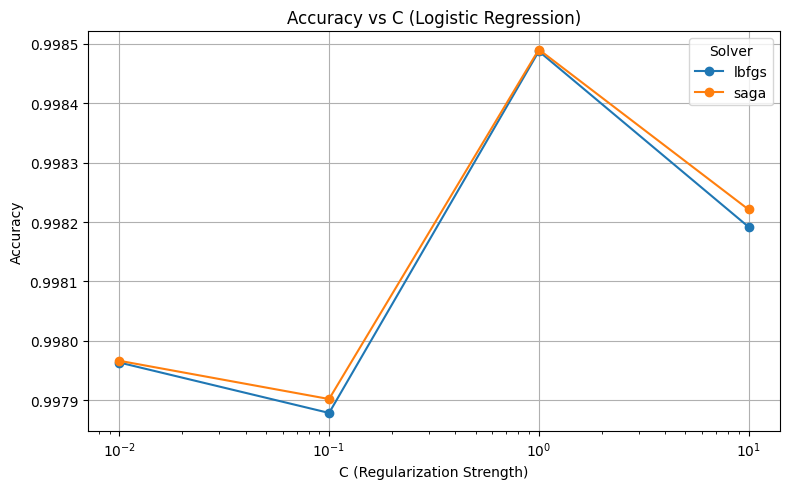

In [52]:
# Plot Accuracy for each solver over different C values
plt.figure(figsize=(8, 5))
for solver in grid_df['solver'].unique():
    subset = grid_df[grid_df['solver'] == solver]
    plt.plot(subset['C'], subset['Accuracy'], marker='o', label=solver)

plt.title("Accuracy vs C (Logistic Regression)")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.grid(True)
plt.legend(title="Solver")
plt.tight_layout()
plt.show()


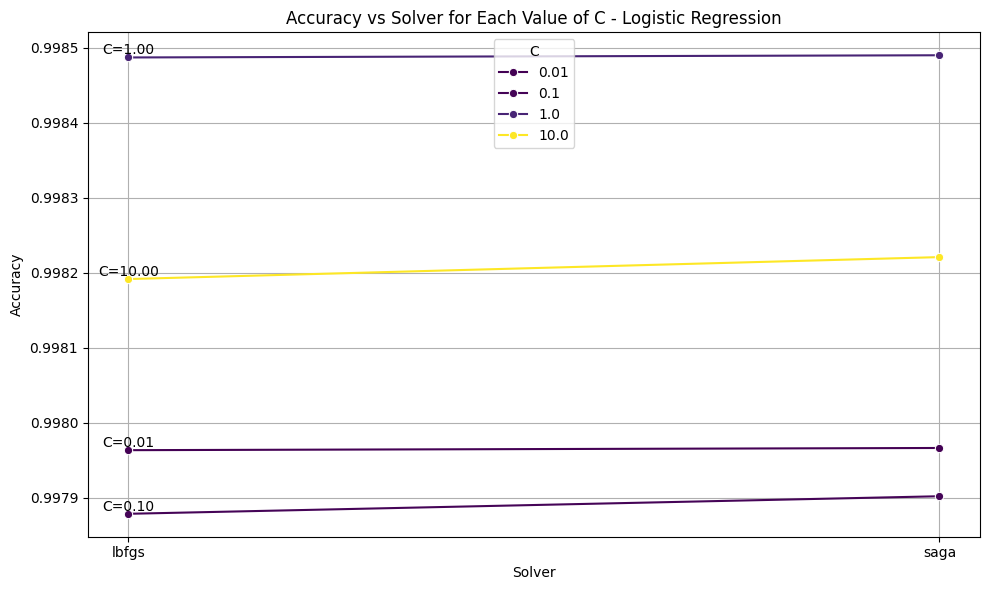

In [54]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=grid_df, x='solver', y='Accuracy', hue='C', marker='o', palette='viridis')

# Title and labels for the line plot
plt.title("Accuracy vs Solver for Each Value of C - Logistic Regression")
plt.xlabel("Solver")
plt.ylabel("Accuracy")
plt.grid(True)

# Adding labels for each value of C, placed above the point
for i in range(0, len(grid_df), len(grid_df)//len(grid_df['C'].unique())):  # Only once per value of C
    plt.text(grid_df['solver'][i], grid_df['Accuracy'][i], 
             f"C={grid_df['C'][i]:.2f}", color='black', fontsize=10, ha='center', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

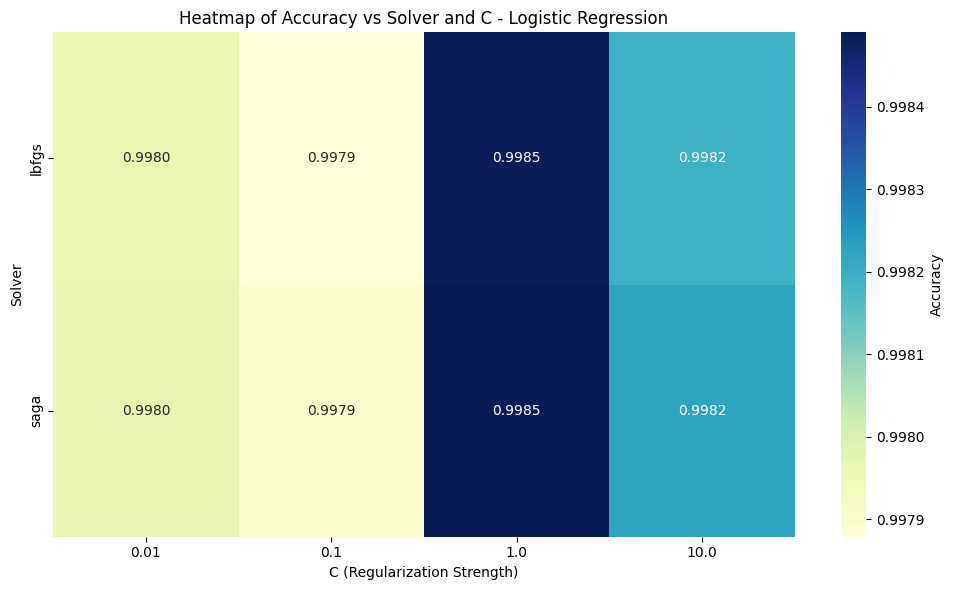

In [55]:
# Pivot the DataFrame to create a matrix for heatmap
heatmap_data = grid_df.pivot(index="solver", columns="C", values="Accuracy")

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".4f", cbar_kws={'label': 'Accuracy'})

# Add title and labels
plt.title("Heatmap of Accuracy vs Solver and C - Logistic Regression")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Solver")
plt.tight_layout()
plt.show()

BEST MODEL

In [31]:
best_model = grid_df.loc[grid_df['Accuracy'].idxmax()]
print("Best Model Parameters:")
print(best_model)

Best Model Parameters:
Accuracy                                    0.99849
Precision                                  0.998891
Recall                                     0.999298
F1-Score                                   0.999094
Normal_Detect_Rate                         0.994453
Atk_Detect_Rate                            0.999298
Training_Time                            475.191032
Confusion_Matrix      [[56649, 316], [200, 284625]]
ROC_AUC                                    0.997422
C                                               1.0
penalty                                          l2
solver                                         saga
Mean_Test_Score                            0.986257
Name: 5, dtype: object


C:\Users\HP\AppData\Local\Temp\ipykernel_2008\2073220672.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


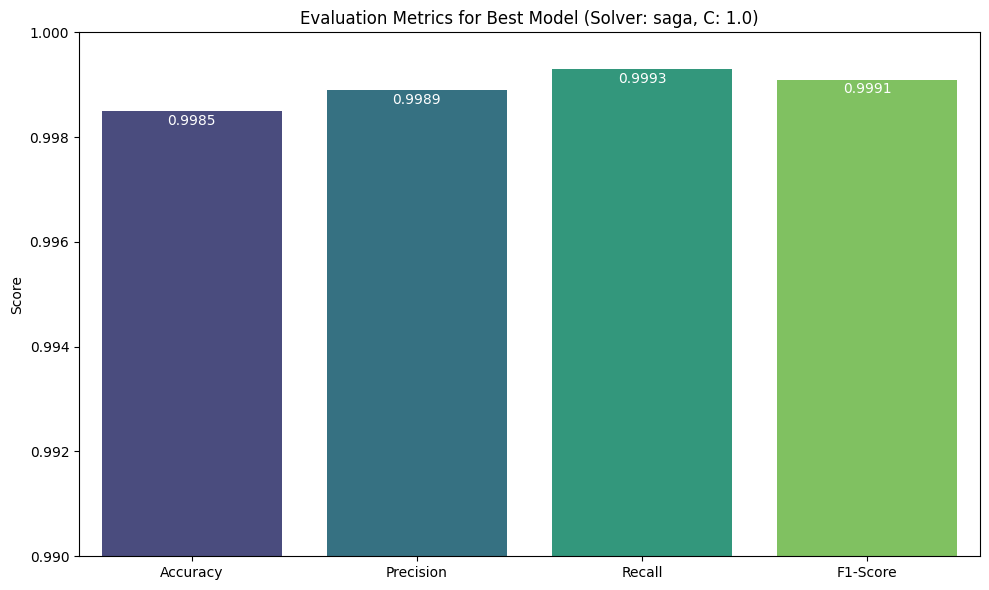

In [47]:
# Prepare evaluation metrics for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [best_model['Accuracy'], best_model['Precision'], best_model['Recall'], best_model['F1-Score']]

# Plot the evaluation metrics as a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='viridis')

# Add labels inside the bars, closer to the top
for i, value in enumerate(values):
    plt.text(i, value - 0.00005 , f'{value:.4f}', ha='center', va='top', color='white')

# Set the y-axis to start from 0.95
plt.ylim(0.99, 1.0)  # Adjust this range as needed

# Add plot title and labels
plt.title(f"Evaluation Metrics for Best Model (Solver: {best_model['solver']}, C: {best_model['C']})")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

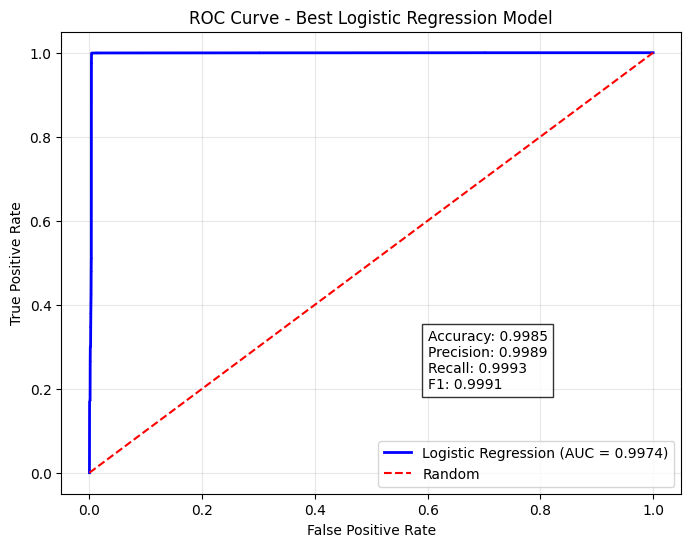

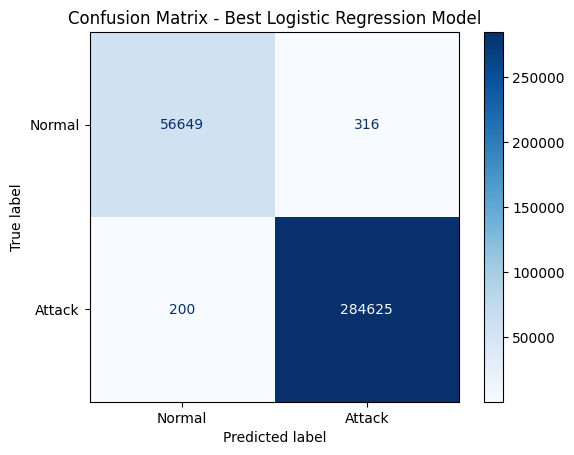

In [5]:
# ==== Load ROC ====
fpr = np.load('lr_best_roc_fpr.npy', allow_pickle=True)
tpr = np.load('lr_best_roc_tpr.npy', allow_pickle=True)
roc_auc = np.load('lr_best_roc_auc.npy', allow_pickle=True)

# ==== Plot ROC Curve ====
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Logistic Regression Model')
plt.legend()
plt.grid(alpha=0.3)

# Annotate metrics
plt.text(0.6, 0.2, f'Accuracy: {best_model_df["Accuracy"].values[0]:.4f}\n'
                   f'Precision: {best_model_df["Precision"].values[0]:.4f}\n'
                   f'Recall: {best_model_df["Recall"].values[0]:.4f}\n'
                   f'F1: {best_model_df["F1-Score"].values[0]:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# ==== Plot Confusion Matrix ====
cm = np.array(best_model_result['Confusion_Matrix'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Logistic Regression Model')
plt.grid(False)
plt.show()